# New Tables: Industry level

* Faire les tableaux suivants:
  * Tableau 4: Kuznet: benchmark → Revision
      * Trouver un tableau avec les déciles pour montrer:
        * turning point croissant pour des villes avec une dominance étatique de plus en plus large
      * Regarder si gdp/cap prix constant
      * Indiquer les turning points dans les tableaux
* Partie 6:
  * Tableau 8: 
    * estimer 2 modèles sur des échantillons differents
      * modèle 1 →  TCZ * Polluted * Period
      * modèle 2 → Target * polluted*Period  
    * Echantillonnage → prendre soit industry soit city industry
      * Big
        * Via Herfhindal 
          * benchmark →Revision
      * Foreign 
        * via output/capital/employment 
      * SOEs
        * via output/capital/employment 
      * SPZ
      * Coastal
    * Chaque tableau avec Panel A pour supérieur threshold, Panel B pour inférieur threshold
  * Tableau 9:
    * Enlever SPZ & Coastal
    * estimer 2 modèles sur des échantillons differents
      * modèle 1 →  TCZ * Polluted * Period
      * modèle 2 → Target * polluted*Period  
    * Idem tableau 8
    
## Instruction Notebook

The notebook allows the user to construct to different level of aggregation:

- `industry`
- `geocode4_corr` -> city

By default, the `aggregation_param` parameter is set to `industry`. To switch to city, change for `geocode4_corr`. Then launch the notebook for new results

In [3]:
import pandas as pd
from Fast_connectCloud import connector
import numpy as np

In [4]:
import sys
sys.path.insert(0,'..')

In [5]:
import functions.latex_beautify as lb

%load_ext autoreload
%autoreload 2

In [6]:
gs = connector.open_connection(online_connection = False,
                              path_credential = '/Users/thomas/Google Drive/Projects/Client_Oauth/Google_auth')

service = gs.connect_remote('GCP')

Service account storage and Bigquery are now connected. 
Service account storage is stored as <google.cloud.storage.client.Client object at 0xa191e1b10> and accessible with "Storage_account" 
Service account Bigquery is stored as <google.cloud.bigquery.client.Client object at 0xa1a107990> and accessible with "bigquery_account"


In [7]:
%put df_final --to R

from GoogleDrivePy.google_platform import connect_cloud_platform
project = 'valid-pagoda-132423'
gcp = connect_cloud_platform.connect_console(project = project, 
                                             service_account = service['GoogleCloudP'])    
query = (
          "SELECT * "
            "FROM China.SBC_pollution_China "

        )

df_final = gcp.upload_data_from_bigquery(query = query, location = 'US')
#df_final.head()

/Users/thomas/anaconda3/lib/python3.7/site-packages/pyarrow/feather.py:83: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(df, _pandas_api.pd.SparseDataFrame):


### Aggregation Parameter

In [8]:
aggregation_param = 'industry' #'geocode4_corr'
list_agg = df_final[aggregation_param].to_list()

In [9]:
%put aggregation_param --to R

In [10]:
options(warn=-1)
shhh <- suppressPackageStartupMessages
shhh(library(tidyverse))
shhh(library(lfe))
shhh(library(lazyeval))
shhh(library('progress'))

path = "../functions/SBC_pollution_R.R"
source(path)
path = "../functions/SBC_pollutiuon_golatex.R"
source(path)

In [11]:
df_final <- df_final %>% 
    mutate_if(is.character, as.factor) %>%
    mutate_at(vars(starts_with("FE")), as.factor) %>%
    mutate(
         Period = relevel(Period, ref='Before'),
         TCZ_c = relevel(TCZ_c, ref='No_TCZ'),
         effort_c = relevel(effort_c, ref='Below'),
         polluted_di = relevel(polluted_di, ref='Below'),
         polluted_mi = relevel(polluted_mi, ref='Below'),
         polluted_thre = relevel(polluted_thre, ref='Below'),
  )
#head(df_final)

# Partie 6

## Table 8

Estimate the following models using different subsamples:

### Models to estimate 

$$
Log SO2 emission _{i k t}=\alpha\left(\text { Period } \times \text { TCZ }_{i} \times \text { Polluting sectors }_{k} \right)+\nu_{i}+\lambda_{t}+\phi_{k}+\epsilon_{i k t}
$$

$$
Log SO2 emission _{i k t}=\alpha\left(\text { Period } \times \text { Target }_{i} \times \text { Polluting sectors }_{k} \right)+\nu_{i}+\lambda_{t}+\phi_{k}+\epsilon_{i k t}
$$

$$
Log SO2 emission _{i k t}=\alpha\left(\text { Period } \times \text { Target }_{i} \times \text { Polluting sectors }_{k} \right)+ \\
\beta\left(\text { Period } \times \text { Target }_{i} \times \text { Polluting sectors }_{k} \right) +\nu_{i}+\lambda_{t}+\phi_{k}+\epsilon_{i k t}
$$

* Size
    * Via Herfhindal 
        * benchmark →Revision
* Foreign 
    * via output/capital/employment 
* SOEs
    * via output/capital/employment 
* SPZ
* Coastal

## Load Data

### Compute Herfhindal: proxy Size

$$
H=\sum_{i=1}^{N} s_{i}^{2}
$$

where $s_i$ is the market share of industry[city] $i$ in a city [industry], and $N$ is the number of firms. 

We proceed as follow:
- Step 1: Compute the share [output, capital, employment] by city-industry: `market_share_cit`
- Step 2: compute the sum of squared market share by industry[city]: `Herfindahl_agg_t`
- Step 3: Compute the average across time: `Herfindahl_agg`
- Step 4: Compute the deciles of step 3: `decile_herfhindal_agg`
    - Low decile implies a low concentration within sectors
    - High decile implies a high concentration within sectors

In [12]:
query = """
WITH sum_cit AS (
  SELECT geocode4_corr, cic as industry, sum(output) as sum_o_cit, year
  FROM China.asif_firm_china 
  WHERE year >= 2002 AND year <= 2007
  AND output > 0 
    AND fa_net > 0 
    AND employment > 0 
  GROUP BY geocode4_corr, cic, year
) 
SELECT * 
FROM 
  (WITH sum_agg_t AS (
    SELECT {0}, SUM(sum_o_cit) as sum_o_agg_t, year
    FROM sum_cit
    WHERE year >= 2002 AND year <= 2007
    GROUP BY year, {0}
)
SELECT *
FROM
  (WITH ms_cit AS (
    SELECT  sum_cit.{0}, sum_cit.geocode4_corr, sum_cit.year,
    sum_cit.sum_o_cit/NULLIF(sum_agg_t.sum_o_agg_t, 0) as market_share_cit
    FROM sum_cit
    LEFT JOIN sum_agg_t
ON (
sum_cit.year = sum_agg_t.year AND 
sum_cit.{0} = sum_agg_t.{0}
)
)
SELECT *
FROM
  (WITH agg_1 AS (
SELECT industry, SUM(POW(market_share_cit, 2)) as Herfindahl_agg_t,
year
FROM ms_cit
GROUP BY year, {0}
ORDER BY year, {0} 
)
SELECT *
FROM (
SELECT {0},
AVG(Herfindahl_agg_t) as Herfindahl_agg
FROM agg_1
GROUP BY {0}
ORDER BY {0}
)

)))
"""

df_herfhindal = (gcp.upload_data_from_bigquery(
    query = query.format(aggregation_param),
                                         location = 'US')
                 .loc[lambda x: x[aggregation_param].isin(list_agg)]
                )
#df_herfhindal.shape

(296, 2)

### Compute Ownership: proxy Foreign/SOE

$$\sum output_{agg,o}/ \sum output_{agg}$$

- with $agg$ stands for industry[city]
- $o$ stands for ownership (Foreign vs Domestic or SOE vs private)



#### Foreign vs domestic

We proceed as follow:
- Step 1: Compute the share [output, capital, employment] by industry[city], ownership (Foreign/Domestic): `Share_X_agg_o`
- ~Step 2: Compute dummy when share Foreign above share domestic by industry[city]~
- Step 3: Compute decile by industry[city]-ownership
    - Note,  high decile in Foreign means the industry[city] has relatively high share of foreign output, but not in absolule value as in step 2. A decile 9 in foreign can be a decile 2 or 3 in Domestic

In [13]:
OWNERSHIP = 'Foreign'
query_share_ = """ 
WITH sum_agg_o AS (
  SELECT 
    case WHEN ownership = '{2}' THEN '{2}' ELSE '{3}' END AS OWNERSHIP, 
    SUM(output / 10000000) as output_agg_o, 
    SUM(fa_net / 10000000) as fa_net_agg_o, 
    SUM(employment / 100000) as employment_agg_o,
    {1} as {0}
  FROM 
    China.asif_firm_china 
  WHERE 
    year >= 2002 
    AND year <= 2007 
    AND output > 0 
    AND fa_net > 0 
    AND employment > 0 
  GROUP BY 
    OWNERSHIP, 
    {0}
) 
SELECT 
  * 
FROM 
  (
    WITH sum_agg AS(
      SELECT 
        SUM(output_agg_o) as output_agg, 
        SUM(fa_net_agg_o) as fa_net_agg, 
        SUM(employment_agg_o) as employment_agg, 
        {0} AS {0}_b
      FROM 
        sum_agg_o 
      GROUP BY 
        {0}
    ) 
    SELECT 
      * 
    FROM 
      (
        WITH share_agg_o AS(
          SELECT 
            OWNERSHIP, 
            output_agg_o / output_agg AS share_output_agg_o, 
            fa_net_agg_o / fa_net_agg AS share_fa_net_agg_o, 
            employment_agg_o / employment_agg AS share_employement_agg_o, 
            {0}
          FROM 
            sum_agg_o 
            LEFT JOIN sum_agg ON sum_agg_o.{0} = sum_agg.{0}_b 
        ) 
        SELECT 
        {0},
        OWNERSHIP,  
        share_output_agg_o,
        share_fa_net_agg_o,
        share_employement_agg_o
        FROM share_agg_o
        WHERE OWNERSHIP = '{2}'
        )
        )
"""
if aggregation_param == 'industry':
    if OWNERSHIP == 'Foreign':
        counterpart = 'DOMESTIC'
    else:
        counterpart = 'PRIVATE'
    query_share_foreign= query_share_.format(aggregation_param,
                                             'cic',
                                             OWNERSHIP,
                                            counterpart)
else:
    if OWNERSHIP == 'Foreign':
        counterpart = 'DOMESTIC'
    else:
        counterpart = 'PRIVATE'
    query_share_foreign = query_share_.format(aggregation_param,
                                              aggregation_param,
                                              OWNERSHIP,
                                             counterpart)
df_share_foreign = (gcp.upload_data_from_bigquery(query = query_share_foreign,
                                         location = 'US')
                    .loc[lambda x: x[aggregation_param].isin(list_agg)]
                   )
#df_share_foreign.shape 

#### SOE

#### Foreign vs domestic

We proceed as follow:
- Step 1: Compute the share [output, capital, employment] by industry[city], ownership (SOE/PRIVATE): `Share_X_agg_o`
- ~Step 2: Compute dummy when share SOE above share domestic by industry[city]~
- Step 3: Compute decile by industry[city]-ownership
    - Note,  high decile in SOE means the industry[city] has relatively high share of SOE output, but not in absolule value as in step 2. A decile 9 in SOE can be a decile 2 or 3 in Domestic

In [14]:
OWNERSHIP = 'SOE'
if aggregation_param == 'industry':
    if OWNERSHIP == 'Foreign':
        counterpart = 'DOMESTIC'
    else:
        counterpart = 'PRIVATE'
    df_share_soe= query_share_.format(aggregation_param,
                                             'cic',
                                             OWNERSHIP,
                                            counterpart)
else:
    if OWNERSHIP == 'Foreign':
        counterpart = 'DOMESTIC'
    else:
        counterpart = 'PRIVATE'
    df_share_soe = query_share_.format(aggregation_param,
                                              aggregation_param,
                                              OWNERSHIP,
                                             counterpart)
    
df_share_soe = (gcp.upload_data_from_bigquery(query = df_share_soe,
                                         location = 'US')
                    .loc[lambda x: x[aggregation_param].isin(list_agg)]
                   )
#df_share_soe.shape 

#df_share_soe['rank_share_output_i'].value_counts().sort_index()

### Load TCZ_list_china from Google Spreadsheet

Feel free to add description about the dataset or any usefull information.

Profiling will be available soon for this dataset

In [18]:
df_TCZ_list_china = read_csv('../df_TCZ_list_china.csv',
                            col_types = cols(
  Province = col_character(),
  City = col_character(),
  geocode4_corr = col_double(),
  TCZ = col_double(),
  SPZ = col_double()
)) %>% 
select(-c(TCZ, Province)) %>% 
left_join(df_final, by = 'geocode4_corr')

### Add to table

In [19]:
%put df_herfhindal_final --to R
df_herfhindal_final = (df_final.merge(df_herfhindal,
                                     on=[aggregation_param],
                                     how='left',
                                     indicator=True
                                     )
                       .assign(
                       decile_herfhindal = lambda x:
                           pd.qcut(x['Herfindahl_agg'],10, labels=False),
                       mean_herfhindal= 
                           lambda x: np.where(
                               x["Herfindahl_agg"] > 
                               x["Herfindahl_agg"].unique().mean(),
                               1,0
                           ),
                       third_herfhindal= 
                           lambda x: np.where(
                               x["Herfindahl_agg"] > 
                               (x["Herfindahl_agg"]
                                .drop_duplicates()
                                .quantile([.75])
                                .values[0]),
                               1,0
                           )
                       )
                      )

INFO: NumExpr defaulting to 8 threads.

In [ ]:
#print('Median: {}'.format(df_herfhindal_final['Herfindahl_agg'].median()))
#print('Mean: {}'.format(df_herfhindal_final["Herfindahl_agg"].mean()))
#print('Third decile: {}'.format(
#    (df_herfhindal_final["Herfindahl_agg"]
#     .drop_duplicates().quantile([.75]).values[0])))
#print(pd.qcut(df_herfhindal_final['Herfindahl_agg'],
#        10).drop_duplicates().sort_values().reset_index(drop = True))

#df_herfhindal_final['decile_herfhindal'].value_counts().sort_index()

In [21]:
df_herfhindal_r <- df_herfhindal_final %>% 
    mutate_if(is.character, as.factor) %>%
    mutate_at(vars(starts_with("FE")), as.factor) %>%
    mutate(
         Period = relevel(Period, ref='Before'),
         TCZ_c = relevel(TCZ_c, ref='No_TCZ'),
         effort_c = relevel(effort_c, ref='Below'),
         polluted_di = relevel(polluted_di, ref='Below'),
         polluted_mi = relevel(polluted_mi, ref='Below'),
         polluted_thre = relevel(polluted_thre, ref='Below'),
  )

In [22]:
%put df_final_SOE --to R
df_final_SOE = (df_final.merge(
    df_share_soe,
    on = [aggregation_param],
    how = 'left',
    indicator = True
)
                .assign(
                       output = lambda x:
                           pd.qcut(x['share_output_agg_o'],10, labels=False),
                       capital = lambda x:
                           pd.qcut(x['share_fa_net_agg_o'],10, labels=False),
                       employment = lambda x:
                           pd.qcut(x['share_employement_agg_o'],10, labels=False),
                       mean_output = lambda x:np.where(
                    x['out_share_SOE'] > x['out_share_SOE'].unique().mean(),
                           1,0
                       ),
                    mean_capital = lambda x:np.where(
                    x['cap_share_SOE'] > x['cap_share_SOE'].unique().mean(),
                           1,0
                       ),
                    mean_employment = lambda x:np.where(
                    x['lab_share_SOE'] > x['lab_share_SOE'].unique().mean(),
                           1,0
                       )
                    )

)
for i in ['output', 'capital', 'employment']:
    if i == 'output':
        v = 'share_output_agg_o'
    elif i =='capital':
        v = 'share_fa_net_agg_o'
    else:
        v = 'share_employement_agg_o'
    #print('Median: {}'.format(df_final_SOE[v].median()))
    #print(pd.qcut(df_final_SOE[v],
    #    10).drop_duplicates().sort_values().reset_index(drop = True))

    #print(df_final_SOE[i].value_counts().sort_index())

In [23]:
df_final_SOE <- df_final_SOE %>% 
    mutate_if(is.character, as.factor) %>%
    mutate_at(vars(starts_with("FE")), as.factor) %>%
    mutate(
         Period = relevel(Period, ref='Before'),
         TCZ_c = relevel(TCZ_c, ref='No_TCZ'),
         effort_c = relevel(effort_c, ref='Below'),
         polluted_di = relevel(polluted_di, ref='Below'),
         polluted_mi = relevel(polluted_mi, ref='Below'),
         polluted_thre = relevel(polluted_thre, ref='Below'),
  )

In [24]:
%put df_final_FOREIGN --to R
df_final_FOREIGN = (df_final.merge(
    df_share_foreign,
    on = [aggregation_param],
    how = 'left',
    indicator = True
)
                .assign(
                       output = lambda x:
                           pd.qcut(x['share_output_agg_o'],10, labels=False),
                       capital = lambda x:
                           pd.qcut(x['share_fa_net_agg_o'],10, labels=False),
                       employment = lambda x:
                           pd.qcut(x['share_employement_agg_o'],10, labels=False),
                    mean_output = lambda x:np.where(
                    x['share_output_agg_o'] > x['share_output_agg_o'].unique().mean(),
                           1,0
                       ),
                    mean_capital = lambda x:np.where(
                    x['share_fa_net_agg_o'] > x['share_fa_net_agg_o'].unique().mean(),
                           1,0
                       ),
                    mean_employment = lambda x:np.where(
                    x['share_employement_agg_o'] > x['share_employement_agg_o'].unique().mean(),
                           1,0
                       )
                    )
)
for i in ['output', 'capital', 'employment']:
    if i == 'output':
        v = 'share_output_agg_o'
    elif i =='capital':
        v = 'share_fa_net_agg_o'
    else:
        v = 'share_employement_agg_o'
    #print('Median: {}'.format(df_final_FOREIGN[v].median()))
    #print(pd.qcut(df_final_FOREIGN[v],
    #    10).drop_duplicates().sort_values().reset_index(drop = True))

    #print(df_final_FOREIGN[i].value_counts().sort_index())

In [25]:
df_final_FOREIGN <- df_final_FOREIGN %>% 
    mutate_if(is.character, as.factor) %>%
    mutate_at(vars(starts_with("FE")), as.factor) %>%
    mutate(
         Period = relevel(Period, ref='Before'),
         TCZ_c = relevel(TCZ_c, ref='No_TCZ'),
         effort_c = relevel(effort_c, ref='Below'),
         polluted_di = relevel(polluted_di, ref='Below'),
         polluted_mi = relevel(polluted_mi, ref='Below'),
         polluted_thre = relevel(polluted_thre, ref='Below'),
  )

## Table 8 Model A: Panel A



In [26]:
change_target <- function(table){
    check_target <- grep("PeriodAfter:polluted_threAbove:target_c$", rownames(table$coef))
    
    if (length(check_target) !=0) {
    rownames(table$coefficients)[check_target] <- 'target_c:PeriodAfter:polluted_threAbove'
    rownames(table$beta)[check_target] <- 'target_c:PeriodAfter:polluted_threAbove'
}
    return (table)
}

### Size

Median

In [27]:
cat <- 'Size'
cut <- 'Median'
threshold <- 5
var_ <- 'decile_herfhindal'
df_to_filter <- df_herfhindal_r
### Remove text, tex and pdf files
toremove <- dir(path=getwd(), pattern=".tex|.pdf|.txt")
file.remove(toremove)


### inferior median
t1 <- felm(formula=log(tso2_cit) ~ 
           TCZ_c * Period * polluted_thre 
           + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(get(var_) <= threshold),
             exactDOF=TRUE)
t1 <-change_target(t1)
t2 <- felm(formula=log(tso2_cit) ~ 
           target_c  * Period * polluted_thre 
           + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(get(var_) <= threshold),
             exactDOF=TRUE)
t2 <-change_target(t2)

t3 <- felm(formula=log(tso2_cit) ~ 
           TCZ_c * Period * polluted_thre 
           + target_c  * Period * polluted_thre 
           + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(get(var_) <= threshold),
             exactDOF=TRUE)
t3 <-change_target(t3)

### superior median
t4 <- felm(formula=log(tso2_cit) ~ 
           TCZ_c * Period * polluted_thre 
           + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(get(var_) > threshold),
             exactDOF=TRUE)
t4 <-change_target(t4)

t5 <- felm(formula=log(tso2_cit) ~ 
           target_c  * Period * polluted_thre 
           + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(get(var_) > threshold),
             exactDOF=TRUE)
t5 <-change_target(t5)

t6 <- felm(formula=log(tso2_cit) ~ 
           TCZ_c * Period * polluted_thre 
           + target_c  * Period * polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(get(var_) > threshold),
             exactDOF=TRUE)
t6 <-change_target(t6)

tables <- list(t1, t2, t3,t4, t5, t6)

fe1 <- list(
    c("City fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("Industry fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("Year fixed effects","Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
            )


table_1 <- go_latex(tables,
                dep_var = "Dependent variable \\text { SO2 emission }_{i k t}",
                title=paste0("Aggregation level ",aggregation_param, " ",cut ,
                             " Herfhindal - ", cat),
                addFE=fe1,
                save=TRUE,
                note = FALSE,
                name="table_1.txt"
                            )

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

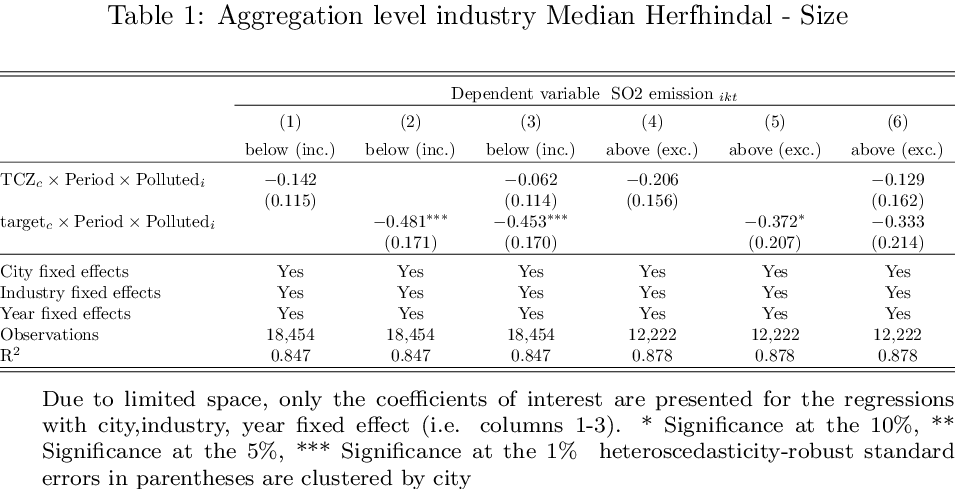

In [30]:
import os
decile=['& below (inc.)', 'below (inc.)', 'below (inc.)',
        'above (exc.)', 'above (exc.)', 'above (exc.)']

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""
lb.beautify(table_number = 1,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
           jupyter_preview = True,
           resolution = 200)

Mean

In [31]:
cat <- 'Size'
cut <- 'Mean'
threshold <- 0
var_ <- 'mean_herfhindal'
df_to_filter <- df_herfhindal_r
### Remove text, tex and pdf files
toremove <- dir(path=getwd(), pattern=".tex|.pdf|.txt")
file.remove(toremove)


### inferior median
t1 <- felm(formula=log(tso2_cit) ~ 
           TCZ_c * Period * polluted_thre 
           + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(decile_herfhindal <= threshold),
             exactDOF=TRUE)
t1 <-change_target(t1)
t2 <- felm(formula=log(tso2_cit) ~ 
           target_c  * Period * polluted_thre 
           + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(decile_herfhindal <= threshold),
             exactDOF=TRUE)
t2 <-change_target(t2)

t3 <- felm(formula=log(tso2_cit) ~ 
           TCZ_c * Period * polluted_thre 
           + target_c  * Period * polluted_thre 
           + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(decile_herfhindal <= threshold),
             exactDOF=TRUE)
t3 <-change_target(t3)

### superior median
t4 <- felm(formula=log(tso2_cit) ~ 
           TCZ_c * Period * polluted_thre 
           + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(decile_herfhindal > threshold),
             exactDOF=TRUE)
t4 <-change_target(t4)

t5 <- felm(formula=log(tso2_cit) ~ 
           target_c  * Period * polluted_thre 
           + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(decile_herfhindal > threshold),
             exactDOF=TRUE)
t5 <-change_target(t5)

t6 <- felm(formula=log(tso2_cit) ~ 
           TCZ_c * Period * polluted_thre 
           + target_c  * Period * polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(decile_herfhindal > threshold),
             exactDOF=TRUE)
t6 <-change_target(t6)

tables <- list(t1, t2, t3,t4, t5, t6)

fe1 <- list(
    c("City fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("Industry fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("Year fixed effects","Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
            )


table_1 <- go_latex(tables,
                dep_var = "Dependent variable \\text { SO2 emission }_{i k t}",
                title=paste0("Aggregation level ",aggregation_param, " ",cut ,
                             " Herfhindal - ", cat),
                addFE=fe1,
                save=TRUE,
                note = FALSE,
                name="table_1.txt"
                            )

[1] TRUE TRUE TRUE

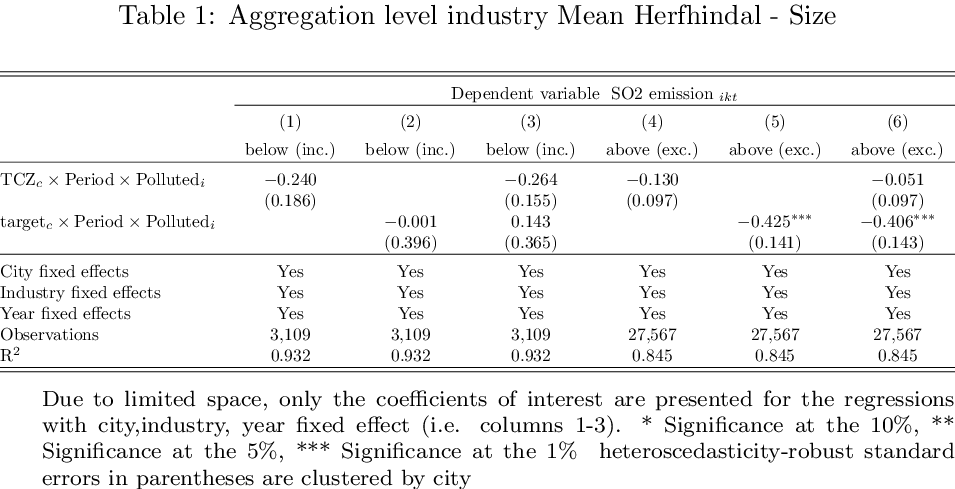

In [32]:
import os
decile=['& below (inc.)', 'below (inc.)', 'below (inc.)',
        'above (exc.)', 'above (exc.)', 'above (exc.)']

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""
lb.beautify(table_number = 1,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
           jupyter_preview = True,
           resolution = 200)

#### Foreign


Median 

In [45]:
cat <- 'Foreign'
cut <- 'Median'
threshold <- 5
#var_ <- 'mean_herfhindal'
df_to_filter <- df_final_FOREIGN
### Remove text, tex and pdf files
toremove <- dir(path=getwd(), pattern=".tex|.pdf|.txt")
file.remove(toremove)

fe1 <- list(
    c("City fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("Industry fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("Year fixed effects","Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

for (var in list('output', 'capital', 'employment')){
    
    ### inferior median
    t1 <- felm(formula=log(tso2_cit) ~ 
               TCZ_c * Period * polluted_thre 
               + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(get(var) <= threshold),
             exactDOF=TRUE)
    t1 <-change_target(t1)
    t2 <- felm(formula=log(tso2_cit) ~ 
           target_c  * Period * polluted_thre 
               + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(get(var) <= threshold),
             exactDOF=TRUE)
    t2 <-change_target(t2)
    t3 <- felm(formula=log(tso2_cit) ~ 
           TCZ_c * Period * polluted_thre 
           + target_c  * Period * polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(get(var) <= threshold),
             exactDOF=TRUE)
    t3 <-change_target(t3)

    ### superior median
    t4 <- felm(formula=log(tso2_cit) ~ 
           TCZ_c * Period * polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(get(var) > threshold),
             exactDOF=TRUE)
    t4 <-change_target(t4)
    t5 <- felm(formula=log(tso2_cit) ~ 
           target_c  * Period * polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(get(var) > threshold),
             exactDOF=TRUE)
    t5 <-change_target(t5)

    t6 <- felm(formula=log(tso2_cit) ~ 
           TCZ_c * Period * polluted_thre 
           + target_c  * Period * polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(get(var) > threshold),
             exactDOF=TRUE)
    t6 <-change_target(t6)
    
    if (var == 'output'){
        tables_o <- list(t1, t2, t3,t4, t5, t6)
        table_1 <- go_latex(tables_o,
                dep_var = "Dependent variable \\text { SO2 emission }_{i k t}",
                title=paste0("Aggregation level ",aggregation_param, " ",cut,
                             " ",var,"  - ", cat),
                addFE=fe1,
                save=TRUE,
                note = FALSE,
                name="table_1.txt"
                           )
    }else if ( var == 'capital'){
        tables_c <- list(t1, t2, t3,t4, t5, t6)
        table_1 <- go_latex(tables_c,
                dep_var = "Dependent variable \\text { SO2 emission }_{i k t}",
                title=paste0("Aggregation level ",aggregation_param, " ",cut,
                             " ",var,"  - ", cat),
                addFE=fe1,
                save=TRUE,
                note = FALSE,
                name="table_2.txt"
                            )
    }else{
        tables_e <- list(t1, t2, t3,t4, t5, t6)
        table_1 <- go_latex(tables_e,
                dep_var = "Dependent variable \\text { SO2 emission }_{i k t}",
                title=paste0("Aggregation level ",aggregation_param, " ",cut,
                             " ",var,"  - ", cat),
                addFE=fe1,
                save=TRUE,
                note = FALSE,
                name="table_3.txt"
                            )
    }
}

[1] TRUE TRUE TRUE TRUE TRUE

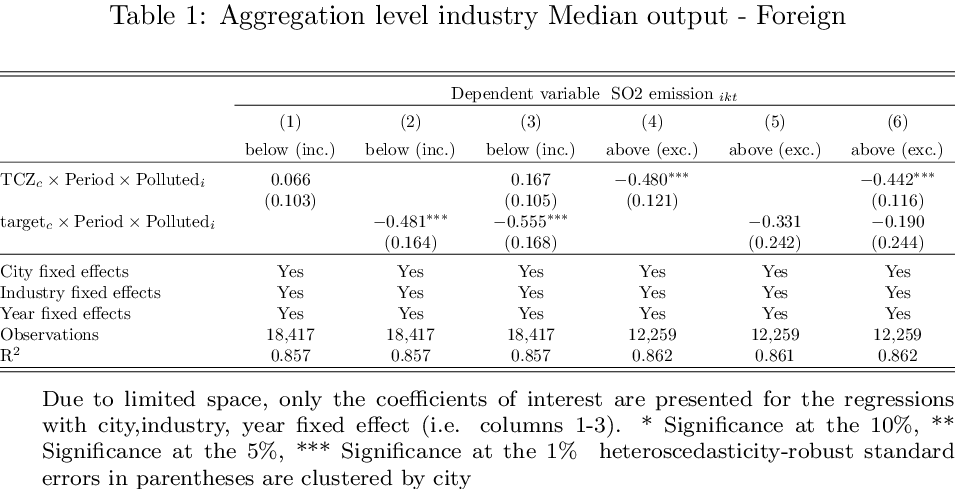

In [46]:
import os
decile=['& below (inc.)', 'below (inc.)', 'below (inc.)',
        'above (exc.)', 'above (exc.)', 'above (exc.)']

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""
lb.beautify(table_number = 1,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
           jupyter_preview = True,
           resolution = 200)

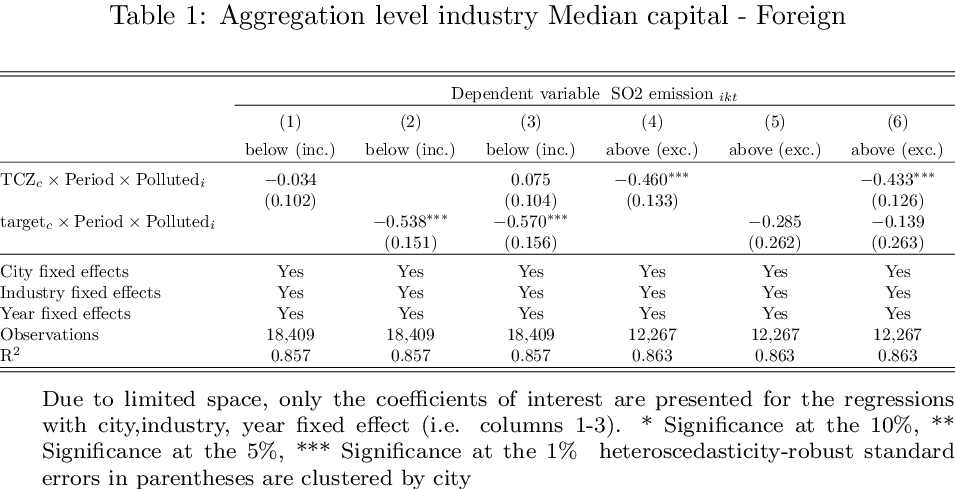

In [47]:
lb.beautify(table_number = 2,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
            jupyter_preview = True,
            resolution = 200)

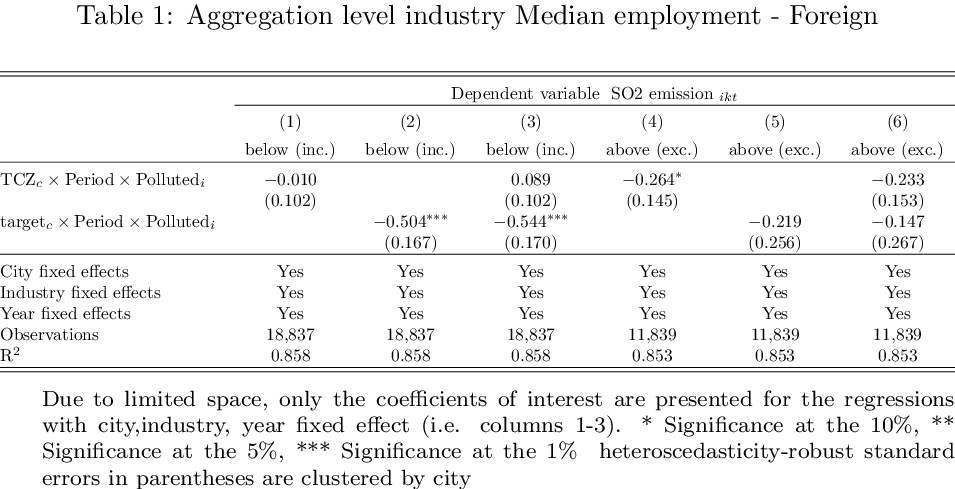

In [48]:
lb.beautify(table_number = 3,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
            jupyter_preview = True,
            resolution = 200)

Mean

In [51]:
cat <- 'Foreign'
cut <- 'Mean'
threshold <- 0
#var_ <- 'mean_herfhindal'
df_to_filter <- df_final_FOREIGN
### Remove text, tex and pdf files
toremove <- dir(path=getwd(), pattern=".tex|.pdf|.txt")
file.remove(toremove)

fe1 <- list(
    c("City fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("Industry fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("Year fixed effects","Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

for (var in list('mean_output', 'mean_capital', 'mean_employment')){
    
    ### inferior median
    t1 <- felm(formula=log(tso2_cit) ~ 
               TCZ_c * Period * polluted_thre 
               + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(get(var) <= threshold),
             exactDOF=TRUE)
    t1 <-change_target(t1)
    t2 <- felm(formula=log(tso2_cit) ~ 
           target_c  * Period * polluted_thre 
               + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(get(var) <= threshold),
             exactDOF=TRUE)
    t2 <-change_target(t2)
    t3 <- felm(formula=log(tso2_cit) ~ 
           TCZ_c * Period * polluted_thre 
           + target_c  * Period * polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(get(var) <= threshold),
             exactDOF=TRUE)
    t3 <-change_target(t3)

    ### superior median
    t4 <- felm(formula=log(tso2_cit) ~ 
           TCZ_c * Period * polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(get(var) > threshold),
             exactDOF=TRUE)
    t4 <-change_target(t4)
    t5 <- felm(formula=log(tso2_cit) ~ 
           target_c  * Period * polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(get(var) > threshold),
             exactDOF=TRUE)
    t5 <-change_target(t5)

    t6 <- felm(formula=log(tso2_cit) ~ 
           TCZ_c * Period * polluted_thre 
           + target_c  * Period * polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(get(var) > threshold),
             exactDOF=TRUE)
    t6 <-change_target(t6)
    
    if (var == 'mean_output'){
        tables_o <- list(t1, t2, t3,t4, t5, t6)
        v= 'output'
        table_1 <- go_latex(tables_o,
                dep_var = "Dependent variable \\text { SO2 emission }_{i k t}",
                title=paste0("Aggregation level ",aggregation_param, " ",cut,
                             " ",v,"  - ", cat),
                addFE=fe1,
                save=TRUE,
                note = FALSE,
                name="table_1.txt"
                           )
    }else if ( var == 'mean_capital'){
        tables_c <- list(t1, t2, t3,t4, t5, t6)
        v= 'capital'
        table_1 <- go_latex(tables_c,
                dep_var = "Dependent variable \\text { SO2 emission }_{i k t}",
                title=paste0("Aggregation level ",aggregation_param, " ",cut,
                             " ",v,"  - ", cat),
                addFE=fe1,
                save=TRUE,
                note = FALSE,
                name="table_2.txt"
                            )
    }else{
        tables_e <- list(t1, t2, t3,t4, t5, t6)
        v= 'employment'
        table_1 <- go_latex(tables_e,
                dep_var = "Dependent variable \\text { SO2 emission }_{i k t}",
                title=paste0("Aggregation level ",aggregation_param, " ",cut,
                             " ",v,"  - ", cat),
                addFE=fe1,
                save=TRUE,
                note = FALSE,
                name="table_3.txt"
                            )
    }
}

[1] TRUE TRUE TRUE TRUE TRUE

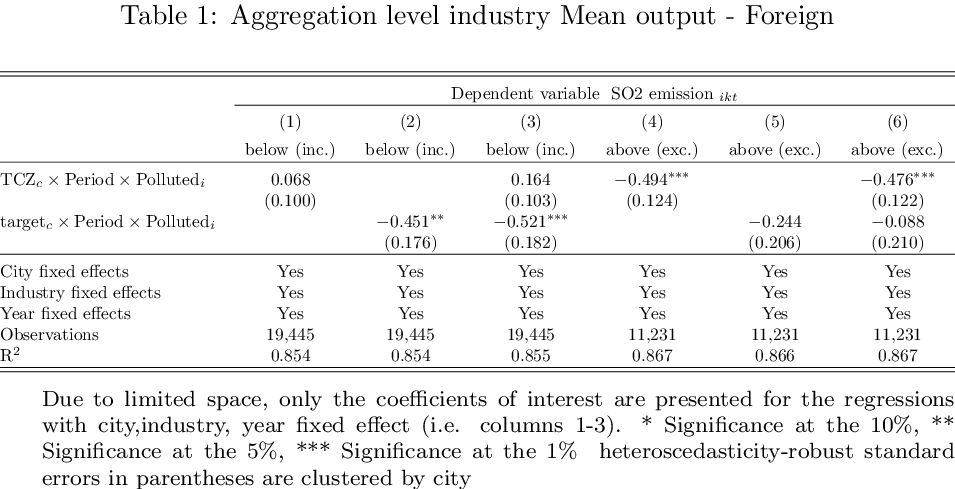

In [52]:
import os
decile=['& below (inc.)', 'below (inc.)', 'below (inc.)',
        'above (exc.)', 'above (exc.)', 'above (exc.)']

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""
lb.beautify(table_number = 1,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
           jupyter_preview = True,
           resolution = 200)

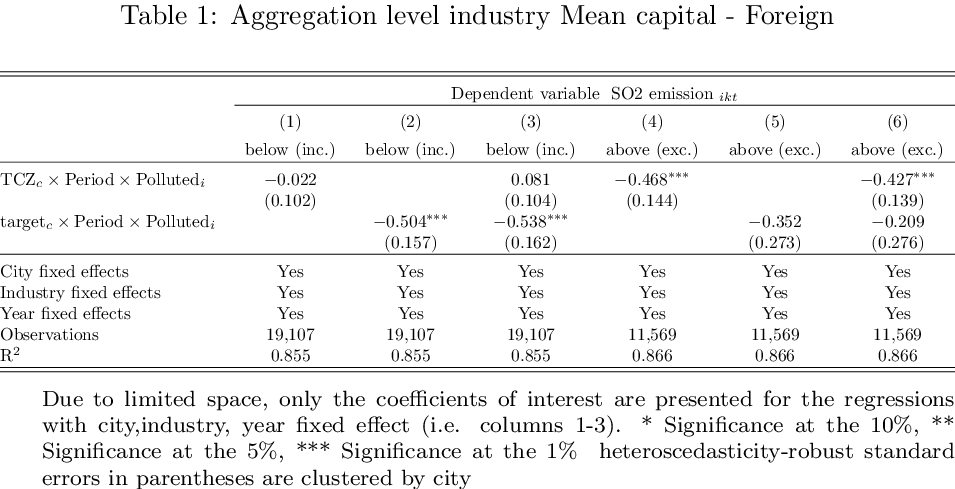

In [53]:
import os
tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""
lb.beautify(table_number = 2,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
           jupyter_preview = True,
           resolution = 200)

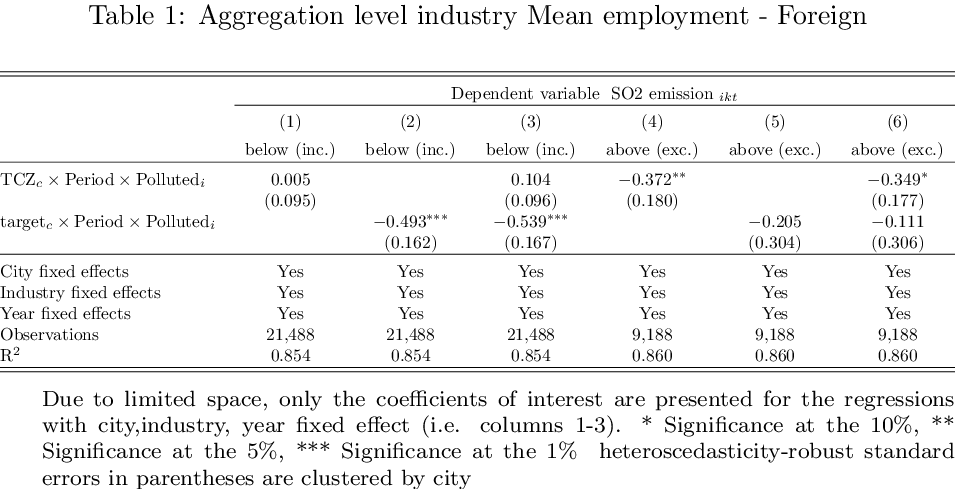

In [54]:
import os

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""
lb.beautify(table_number = 3,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
           jupyter_preview = True,
           resolution = 200)

#### SOE

median

In [55]:
cat <- 'SOE'
cut <- 'Median'
threshold <- 5
#var_ <- 'mean_herfhindal'
df_to_filter <- df_final_SOE
### Remove text, tex and pdf files
toremove <- dir(path=getwd(), pattern=".tex|.pdf|.txt")
file.remove(toremove)

fe1 <- list(
    c("City fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("Industry fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("Year fixed effects","Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

for (var in list('output', 'capital', 'employment')){
    
    ### inferior median
    t1 <- felm(formula=log(tso2_cit) ~ 
               TCZ_c * Period * polluted_thre 
               + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(get(var) <= threshold),
             exactDOF=TRUE)
    t1 <-change_target(t1)
    t2 <- felm(formula=log(tso2_cit) ~ 
           target_c  * Period * polluted_thre 
               + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(get(var) <= threshold),
             exactDOF=TRUE)
    t2 <-change_target(t2)
    t3 <- felm(formula=log(tso2_cit) ~ 
           TCZ_c * Period * polluted_thre 
           + target_c  * Period * polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(get(var) <= threshold),
             exactDOF=TRUE)
    t3 <-change_target(t3)

    ### superior median
    t4 <- felm(formula=log(tso2_cit) ~ 
           TCZ_c * Period * polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(get(var) > threshold),
             exactDOF=TRUE)
    t4 <-change_target(t4)
    t5 <- felm(formula=log(tso2_cit) ~ 
           target_c  * Period * polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(get(var) > threshold),
             exactDOF=TRUE)
    t5 <-change_target(t5)

    t6 <- felm(formula=log(tso2_cit) ~ 
           TCZ_c * Period * polluted_thre 
           + target_c  * Period * polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(get(var) > threshold),
             exactDOF=TRUE)
    t6 <-change_target(t6)
    
    if (var == 'output'){
        tables_o <- list(t1, t2, t3,t4, t5, t6)
        table_1 <- go_latex(tables_o,
                dep_var = "Dependent variable \\text { SO2 emission }_{i k t}",
                title=paste0("Aggregation level ",aggregation_param, " ",cut,
                             " ",var,"  - ", cat),
                addFE=fe1,
                save=TRUE,
                note = FALSE,
                name="table_1.txt"
                           )
    }else if ( var == 'capital'){
        tables_c <- list(t1, t2, t3,t4, t5, t6)
        table_1 <- go_latex(tables_c,
                dep_var = "Dependent variable \\text { SO2 emission }_{i k t}",
                title=paste0("Aggregation level ",aggregation_param, " ",cut,
                             " ",var,"  - ", cat),
                addFE=fe1,
                save=TRUE,
                note = FALSE,
                name="table_2.txt"
                            )
    }else{
        tables_e <- list(t1, t2, t3,t4, t5, t6)
        table_1 <- go_latex(tables_e,
                dep_var = "Dependent variable \\text { SO2 emission }_{i k t}",
                title=paste0("Aggregation level ",aggregation_param, " ",cut,
                             " ",var,"  - ", cat),
                addFE=fe1,
                save=TRUE,
                note = FALSE,
                name="table_3.txt"
                            )
    }
}

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

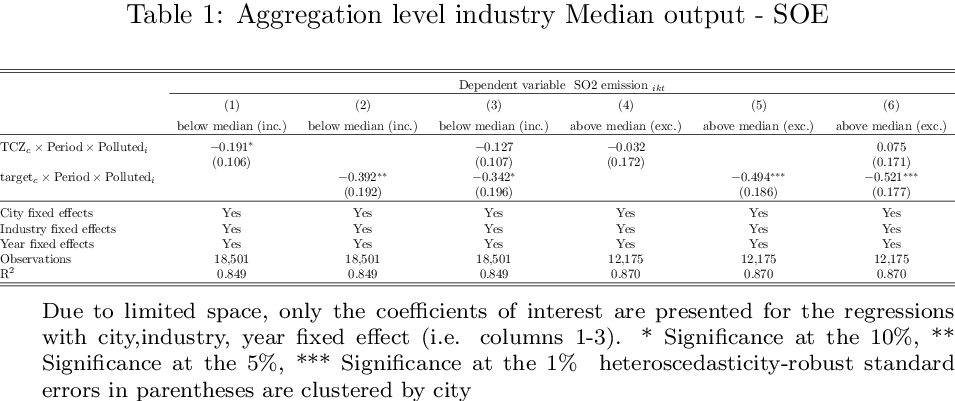

In [56]:
import os
decile=['& below median (inc.)', 'below median (inc.)', 'below median (inc.)',
        'above median (exc.)', 'above median (exc.)', 'above median (exc.)']

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""
lb.beautify(table_number = 1,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
           jupyter_preview = True,
           resolution = 200)

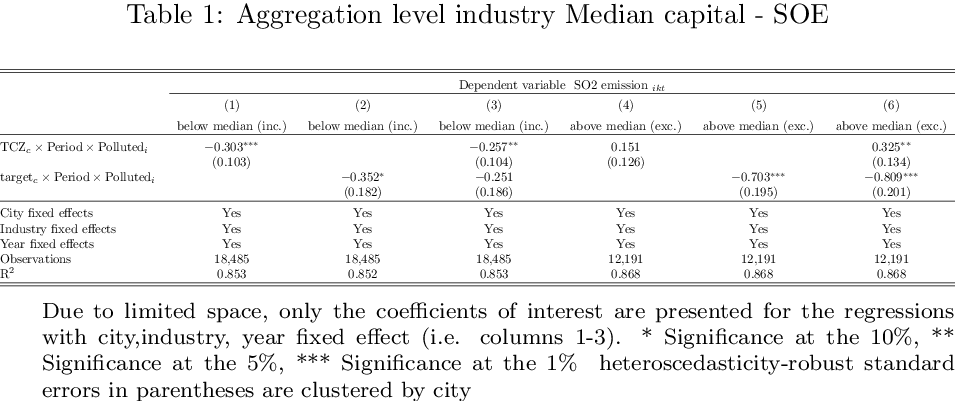

In [57]:
import os
decile=['& below median (inc.)', 'below median (inc.)', 'below median (inc.)',
        'above median (exc.)', 'above median (exc.)', 'above median (exc.)']

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""
lb.beautify(table_number = 2,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
           jupyter_preview = True,
           resolution = 200)

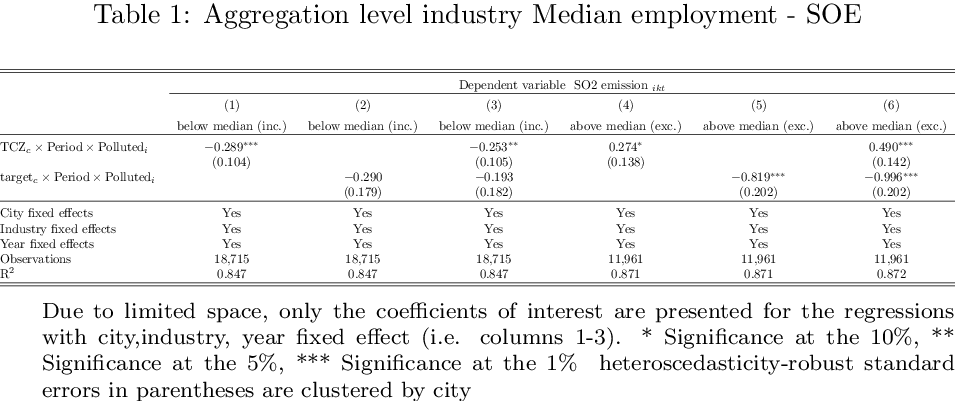

In [58]:
import os
decile=['& below median (inc.)', 'below median (inc.)', 'below median (inc.)',
        'above median (exc.)', 'above median (exc.)', 'above median (exc.)']

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""
lb.beautify(table_number = 3,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
           jupyter_preview = True,
           resolution = 200)

Median

In [59]:
cat <- 'SOE'
cut <- 'Mean'
threshold <- 0
#var_ <- 'mean_herfhindal'
df_to_filter <- df_final_SOE
### Remove text, tex and pdf files
toremove <- dir(path=getwd(), pattern=".tex|.pdf|.txt")
file.remove(toremove)

fe1 <- list(
    c("City fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("Industry fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("Year fixed effects","Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

for (var in list('mean_output', 'mean_capital', 'mean_employment')){
    
    ### inferior median
    t1 <- felm(formula=log(tso2_cit) ~ 
               TCZ_c * Period * polluted_thre 
               + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(get(var) <= threshold),
             exactDOF=TRUE)
    t1 <-change_target(t1)
    t2 <- felm(formula=log(tso2_cit) ~ 
           target_c  * Period * polluted_thre 
               + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(get(var) <= threshold),
             exactDOF=TRUE)
    t2 <-change_target(t2)
    t3 <- felm(formula=log(tso2_cit) ~ 
           TCZ_c * Period * polluted_thre 
           + target_c  * Period * polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(get(var) <= threshold),
             exactDOF=TRUE)
    t3 <-change_target(t3)

    ### superior median
    t4 <- felm(formula=log(tso2_cit) ~ 
           TCZ_c * Period * polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(get(var) > threshold),
             exactDOF=TRUE)
    t4 <-change_target(t4)
    t5 <- felm(formula=log(tso2_cit) ~ 
           target_c  * Period * polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(get(var) > threshold),
             exactDOF=TRUE)
    t5 <-change_target(t5)

    t6 <- felm(formula=log(tso2_cit) ~ 
           TCZ_c * Period * polluted_thre 
           + target_c  * Period * polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(get(var) > threshold),
             exactDOF=TRUE)
    t6 <-change_target(t6)
    
    if (var == 'mean_output'){
        tables_o <- list(t1, t2, t3,t4, t5, t6)
        v = 'output'
        table_1 <- go_latex(tables_o,
                dep_var = "Dependent variable \\text { SO2 emission }_{i k t}",
                title=paste0("Aggregation level ",aggregation_param, " ",cut,
                             " ",v,"  - ", cat),
                addFE=fe1,
                save=TRUE,
                note = FALSE,
                name="table_1.txt"
                           )
    }else if ( var == 'mean_capital'){
        tables_c <- list(t1, t2, t3,t4, t5, t6)
        v = 'capital'
        table_1 <- go_latex(tables_c,
                dep_var = "Dependent variable \\text { SO2 emission }_{i k t}",
                title=paste0("Aggregation level ",aggregation_param, " ",cut,
                             " ",v,"  - ", cat),
                addFE=fe1,
                save=TRUE,
                note = FALSE,
                name="table_2.txt"
                            )
    }else{
        tables_e <- list(t1, t2, t3,t4, t5, t6)
        v = 'employment'
        table_1 <- go_latex(tables_e,
                dep_var = "Dependent variable \\text { SO2 emission }_{i k t}",
                title=paste0("Aggregation level ",aggregation_param, " ",cut,
                             " ",v,"  - ", cat),
                addFE=fe1,
                save=TRUE,
                note = FALSE,
                name="table_3.txt"
                            )
    }
}

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

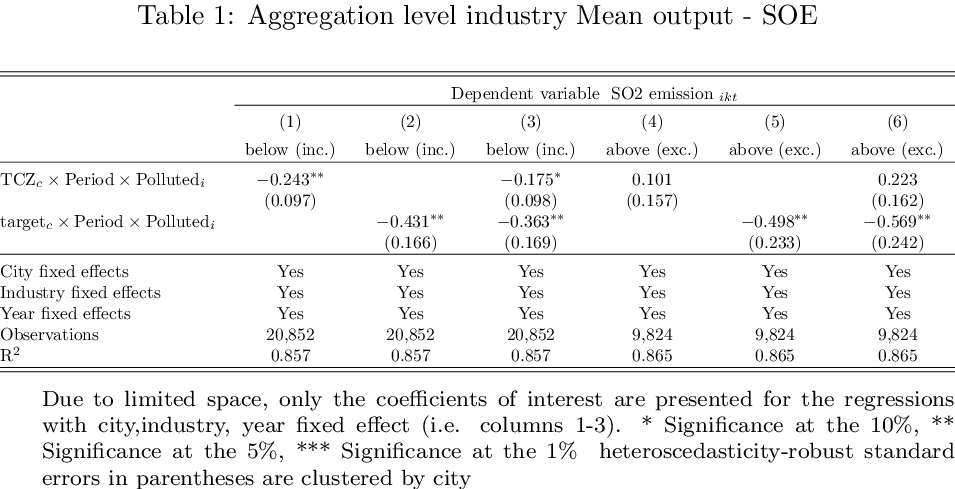

In [60]:
import os
decile=['& below (inc.)', 'below (inc.)', 'below (inc.)',
        'above (exc.)', 'above (exc.)', 'above (exc.)']

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""
lb.beautify(table_number = 1,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
           jupyter_preview = True,
           resolution = 200)

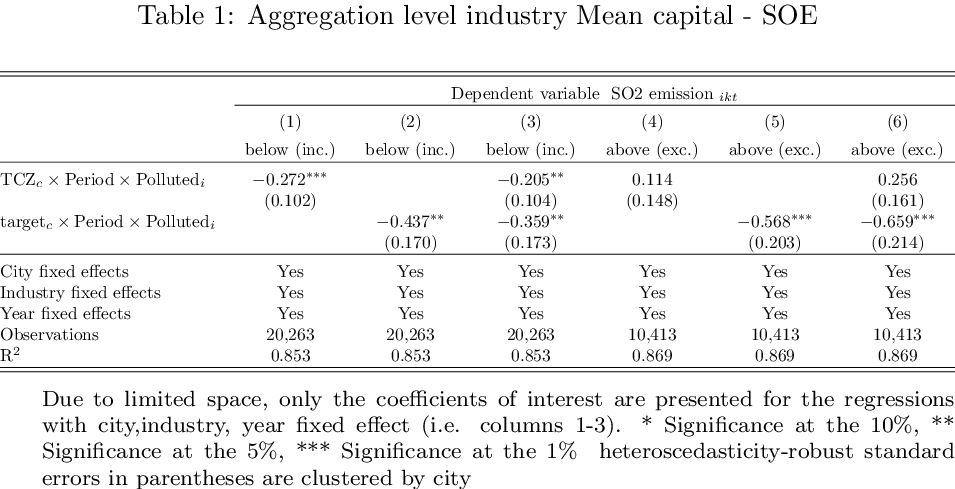

In [61]:
import os

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""
lb.beautify(table_number = 2,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
           jupyter_preview = True,
           resolution = 200)

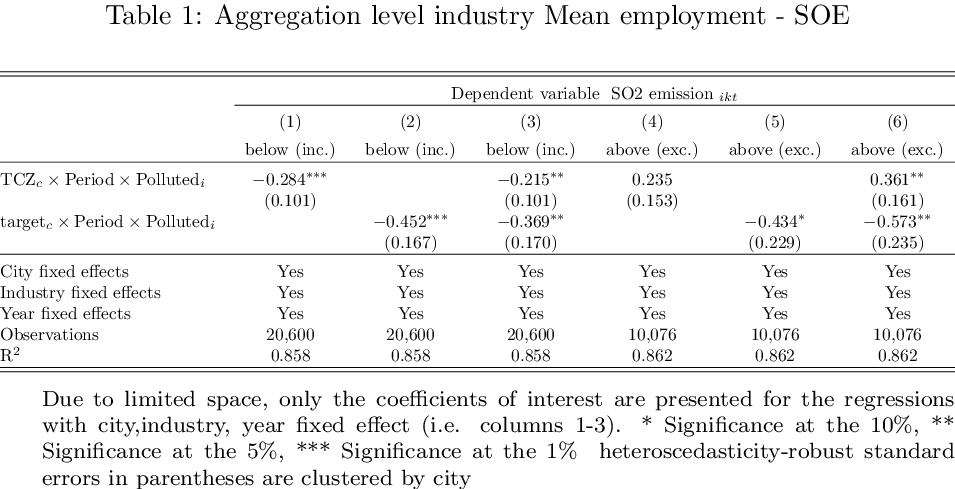

In [62]:
import os

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""
lb.beautify(table_number = 3,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
           jupyter_preview = True,
           resolution = 200)

## SPZ/Coastal

In [63]:
df_to_filter <- df_TCZ_list_china
### SPZ

### Remove text, tex and pdf files
toremove <- dir(path=getwd(), pattern=".tex|.pdf|.txt")
file.remove(toremove)

fe1 <- list(
    c("City fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("Industry fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("Year fixed effects","Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

for (var in range(1,2)){
    
    if (var == 1){
        filter_spz = 1
        filter_coast = TRUE
        filter_tcz = 'TCZ'
        
    }else if ( var == 2){
        
        filter_spz = 0
        filter_coast = FALSE
        filter_tcz = 'No_TCZ'
    }


    t1 <- felm(formula=log(tso2_cit) ~ 
               TCZ_c * Period * polluted_thre 
               + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(SPZ == filter_spz),
             exactDOF=TRUE)
    t1 <-change_target(t1)
    t2 <- felm(formula=log(tso2_cit) ~ 
           target_c  * Period * polluted_thre 
               + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(SPZ == filter_spz),
             exactDOF=TRUE)
    t2 <-change_target(t2)

    t3 <- felm(formula=log(tso2_cit) ~ 
           TCZ_c * Period * polluted_thre 
           + target_c  * Period * polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(SPZ == filter_spz),
             exactDOF=TRUE)
    t3 <-change_target(t3)

    ### Coastal
    t4 <- felm(formula=log(tso2_cit) ~ 
           TCZ_c * Period * polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(Coastal == filter_coast),
             exactDOF=TRUE)
    t4 <-change_target(t4)

    t5 <- felm(formula=log(tso2_cit) ~ 
           target_c  * Period * polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(Coastal == filter_coast),
             exactDOF=TRUE)
    t5 <-change_target(t5)

    t6 <- felm(formula=log(tso2_cit) ~ 
           TCZ_c * Period * polluted_thre 
           + target_c  * Period * polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_to_filter %>% filter(Coastal == filter_coast),
             exactDOF=TRUE)
    t6 <-change_target(t6)

    t7 <- felm(formula=log(tso2_cit) ~ 
           + target_c  * Period * polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_final %>% filter(TCZ_c == filter_tcz),
             exactDOF=TRUE)
    t7 <-change_target(t7)
    
     if (var == 1){
        tables_1 <- list(t1, t2, t3,t4, t5, t6, t7)
        table_1 <- go_latex(tables_1,
                dep_var = "Dependent variable \\text { SO2 emission }_{i k t}",
                title="SPZ/Coastal/TCZ True",
                addFE=fe1,
                save=TRUE,
                note = FALSE,
                name="table_1.txt"
                            )
        
    }else if (var == 2){
        
        tables_2 <- list(t1, t2, t3,t4, t5, t6, t7)
        table_1 <- go_latex(tables_2,
                dep_var = "Dependent variable \\text { SO2 emission }_{i k t}",
                title="SPZ/Coastal/TCZ False",
                addFE=fe1,
                save=TRUE,
                note = FALSE,
                name="table_2.txt"
                            )
    }
    
}

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

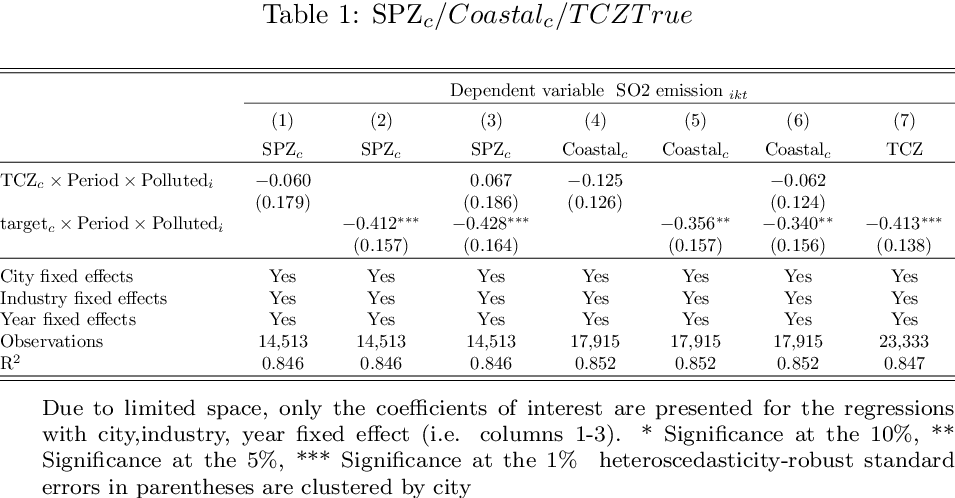

In [64]:
import os
decile=['& SPZ', 'SPZ', 'SPZ',
        'Coastal', 'Coastal', 'Coastal', 'TCZ']

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""
lb.beautify(table_number = 1,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
           jupyter_preview = True,
           resolution = 200)

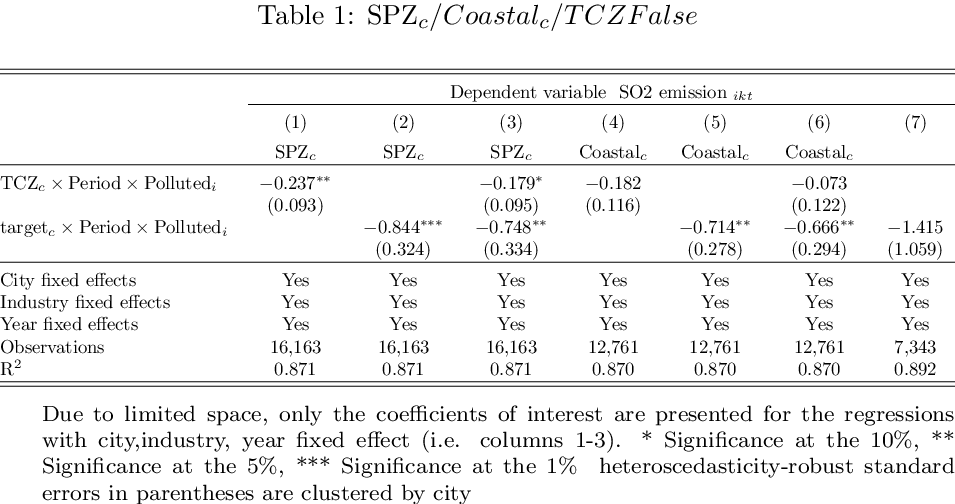

In [65]:
import os
decile=['& SPZ', 'SPZ', 'SPZ',
        'Coastal', 'Coastal', 'Coastal']

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""
lb.beautify(table_number = 2,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
           jupyter_preview = True,
           resolution = 200)

# Create Report

In [69]:
import os, time, shutil
from pathlib import Path

filename = '08_SBC_pollution_China_Revision_New_tables'
source = filename + '.ipynb'
source_to_move = filename + '.html'
path = os.getcwd()
parent_path = str(Path(path).parent)
path_report = "{}/Reports".format(parent_path)
dest = os.path.join(path_report, filename)+'_{}.html'.format(aggregation_param)

os.system('jupyter nbconvert --no-input --to html {}'.format(source))
shutil.move(source_to_move, dest)

time.sleep(5)
for i in range(1, 19):
    try:
        os.remove("table_{}.pdf".format(i))
        os.remove("table_{}.tex".format(i))
        os.remove("table_{}.txt".format(i))
    except:
        pass